--- 1. Generating Synthetic Diabetes Readmission Data ---
Synthetic Readmission Rate: 0.74

Synthetic Data Head:
  age_group  num_lab_procedures  num_medications  num_diagnoses  \
0   [60-70)                  56                1              2   
1   [30-40)                  55                4             13   
2   [70-80)                  61               39              3   
3   [40-50)                  28               26              9   
4   [60-70)                  86               33             11   

   num_inpatient_visits  num_emergency_visits  time_in_hospital_days  \
0                     2                     0                     10   
1                     2                     0                      8   
2                     0                     2                      8   
3                     4                     1                      5   
4                     3                     0                      4   

  glucose_test_result A1C_test_result change_in_med

C:\Users\gangl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:33:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model trained successfully.

--- 4. Evaluating Model Performance ---
Accuracy: 0.7940
Precision: 0.8511
Recall: 0.8742
F1-Score: 0.8625
ROC AUC: 0.8548

Confusion Matrix:
[[148 113]
 [ 93 646]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.57      0.59       261
           1       0.85      0.87      0.86       739

    accuracy                           0.79      1000
   macro avg       0.73      0.72      0.73      1000
weighted avg       0.79      0.79      0.79      1000



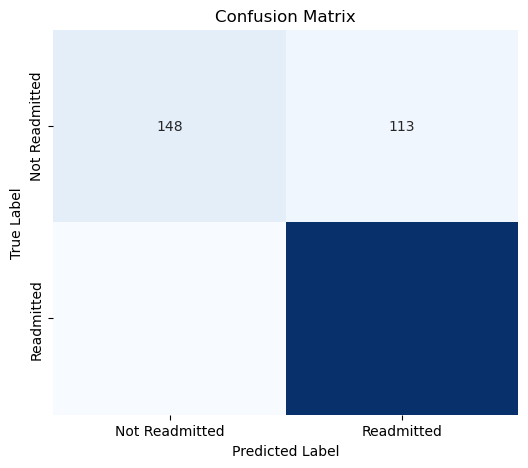


--- 5. Default XGBoost Feature Importance ---
Top 10 Most Important Features (Default):
                     Feature  Importance
14        A1C_test_result_>9    0.220686
10  glucose_test_result_High    0.153129
18        change_in_meds_Yes    0.136861
9         age_group_[90-100)    0.061524
0           age_group_[0-10)    0.048137
17         change_in_meds_No    0.043185
8          age_group_[80-90)    0.039874
11   glucose_test_result_Low    0.033829
7          age_group_[70-80)    0.033389
20          diabetes_med_Yes    0.032852


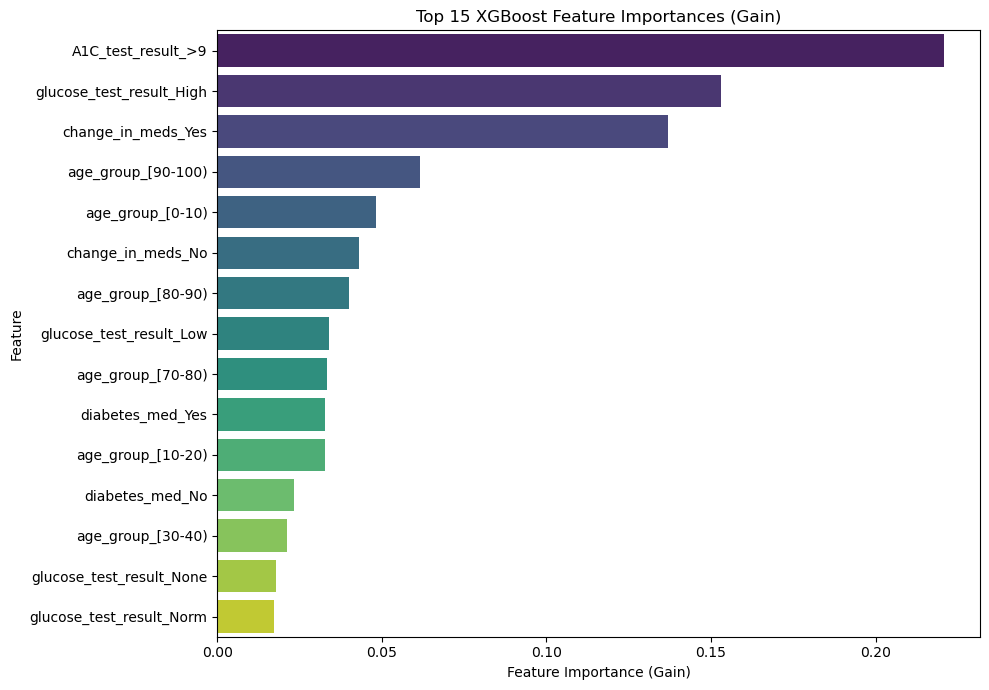


--- 6. SHAP Analysis for Model Interpretability ---

Generating SHAP Summary Plot...


C:\Users\gangl\AppData\Local\Temp\ipykernel_51852\313497929.py:205: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)


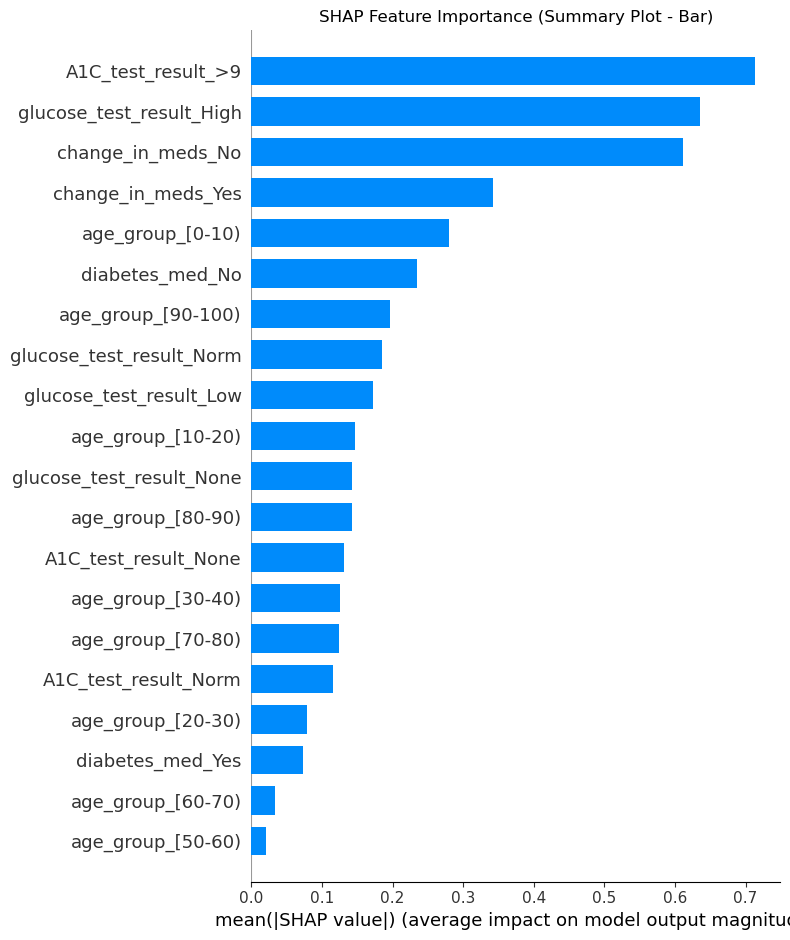


Generating SHAP Beeswarm Plot (shows distribution of impact)...


C:\Users\gangl\AppData\Local\Temp\ipykernel_51852\313497929.py:212: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_df, show=False)


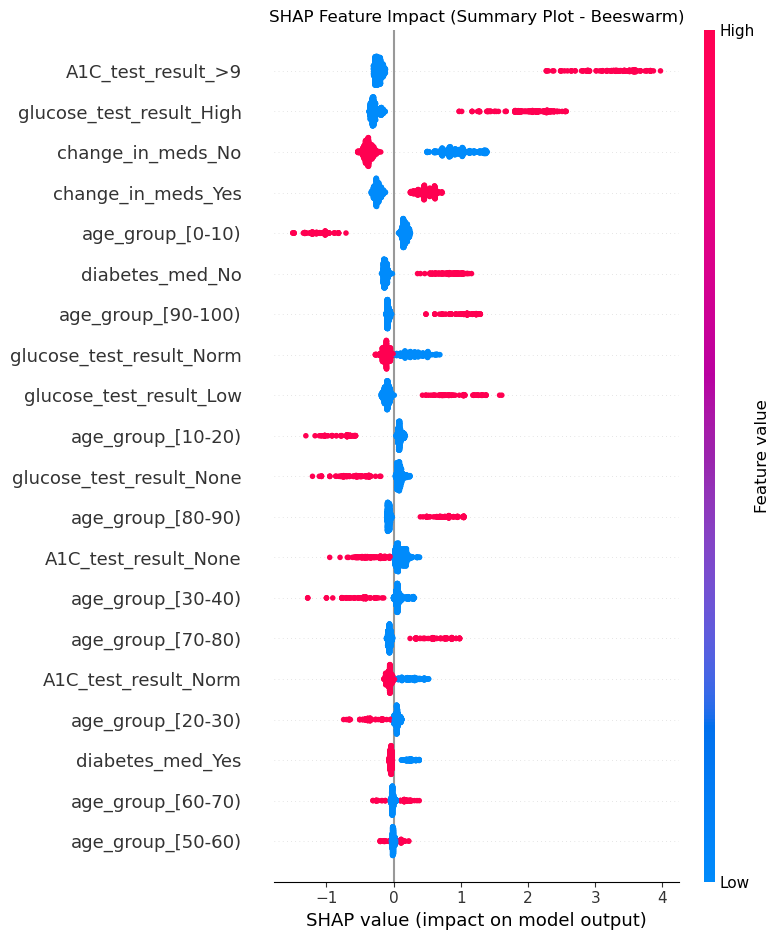


Generating SHAP Waterfall Plot for instance 0...


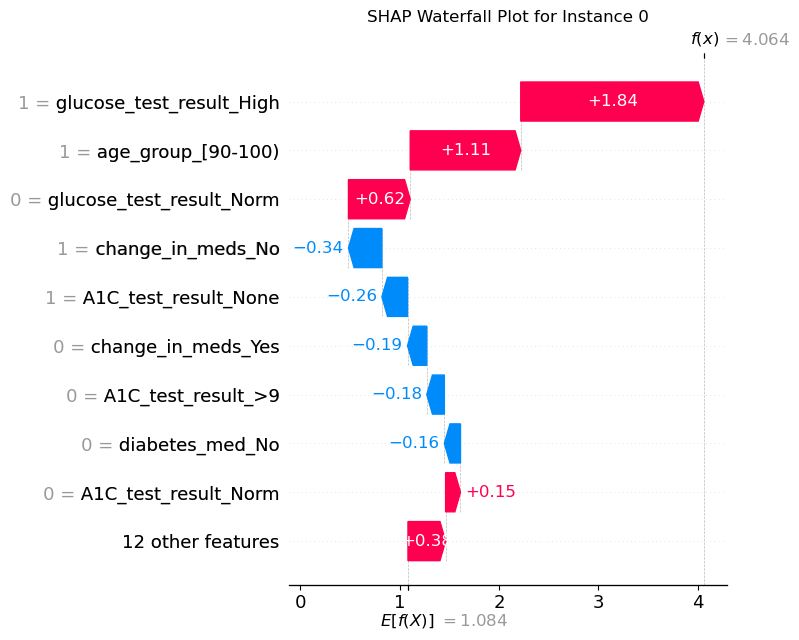


Generating SHAP Force Plot for instance 10 (Interactive in Notebook)...


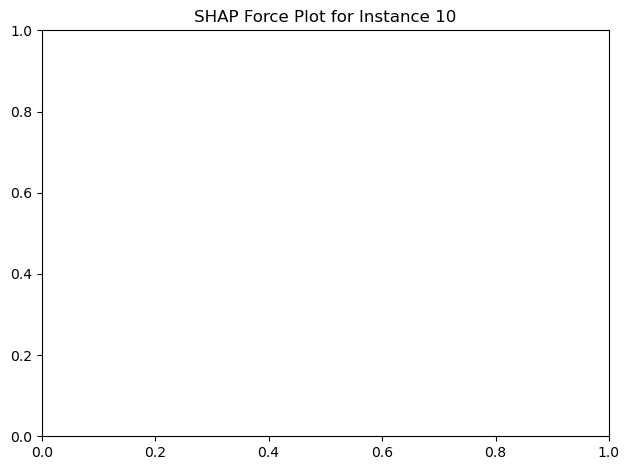


--- SHAP Analysis Complete ---

--- Prediction Example Complete ---


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap # Import the SHAP library

# --- 1. Synthetic Data Generation ---
print("--- 1. Generating Synthetic Diabetes Readmission Data ---")

np.random.seed(42)
num_patients = 5000

# Generate features
data = {
    'age_group': np.random.choice(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'], num_patients),
    'num_lab_procedures': np.random.randint(10, 100, num_patients),
    'num_medications': np.random.randint(1, 50, num_patients),
    'num_diagnoses': np.random.randint(1, 15, num_patients),
    'num_inpatient_visits': np.random.randint(0, 5, num_patients),
    'num_emergency_visits': np.random.randint(0, 3, num_patients),
    'time_in_hospital_days': np.random.randint(1, 15, num_patients),
    'glucose_test_result': np.random.choice(['Norm', 'High', 'Low', 'None'], num_patients, p=[0.6, 0.2, 0.1, 0.1]),
    'A1C_test_result': np.random.choice(['Norm', '>9', 'None'], num_patients, p=[0.7, 0.15, 0.15]),
    'change_in_meds': np.random.choice(['Yes', 'No'], num_patients, p=[0.4, 0.6]),
    'diabetes_med': np.random.choice(['Yes', 'No'], num_patients, p=[0.85, 0.15]),
}

df = pd.DataFrame(data)

# Generate target variable (readmitted) based on some plausible logic
# Factors increasing readmission probability: older age, more lab procedures, more medications,
# more diagnoses, higher inpatient/emergency visits, longer hospital stay, abnormal glucose/A1C,
# change in meds, not on diabetes med.
df['readmitted_prob'] = (
    # Corrected age_group parsing to extract the numeric lower bound
    df['age_group'].apply(lambda x: 0.1 + int(x.strip('[]').split('-')[0])/100 * 0.2) + # Older age -> higher prob
    df['num_inpatient_visits'] * 0.05 +
    df['num_emergency_visits'] * 0.1 +
    df['time_in_hospital_days'] * 0.01 +
    df['glucose_test_result'].apply(lambda x: 0.2 if x == 'High' else (0.1 if x == 'Low' else 0)) +
    df['A1C_test_result'].apply(lambda x: 0.3 if x == '>9' else 0) +
    df['change_in_meds'].apply(lambda x: 0.15 if x == 'Yes' else 0) +
    df['diabetes_med'].apply(lambda x: 0.1 if x == 'No' else 0) +
    np.random.normal(0, 0.05, num_patients) # Add some noise
)

df['readmitted'] = (df['readmitted_prob'] > 0.5).astype(int) # Threshold for readmission

# Ensure balanced enough classes for demonstration (adjust threshold if needed)
readmission_rate = df['readmitted'].mean()
print(f"Synthetic Readmission Rate: {readmission_rate:.2f}")

print("\nSynthetic Data Head:")
print(df.head())
print("\nSynthetic Data Info:")
df.info()
print("\nReadmission Value Counts:")
print(df['readmitted'].value_counts())

# --- 2. Data Preprocessing ---
print("\n--- 2. Data Preprocessing ---")

# Separate features (X) and target (y) before identifying feature types
X = df.drop(columns=['readmitted', 'readmitted_prob'])
y = df['readmitted']

# Identify categorical and numerical features from X (which no longer contains target/prob columns)
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler() # Scaling numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-hot encode categorical features

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Apply preprocessing to training and testing data
# Convert to dense arrays here to ensure consistency for model and SHAP
X_train_processed = preprocessor.fit_transform(X_train).toarray()
X_test_processed = preprocessor.transform(X_test).toarray()

# Get feature names after one-hot encoding for XGBoost
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(categorical_feature_names)

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Number of features after preprocessing: {len(all_feature_names)}")

# --- 3. Model Training (XGBoost Classifier) ---
print("\n--- 3. Training XGBoost Classifier ---")

# Initialize XGBoost Classifier
# Using common parameters; tuning these is crucial for real-world scenarios
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic', # For binary classification
    eval_metric='logloss',       # Evaluation metric for optimization
    n_estimators=200,            # Number of boosting rounds (trees)
    learning_rate=0.1,           # Step size shrinkage
    max_depth=5,                 # Maximum depth of a tree
    subsample=0.8,               # Subsample ratio of the training instance
    colsample_bytree=0.8,        # Subsample ratio of columns when constructing each tree
    use_label_encoder=False,     # Suppress warning for future versions
    random_state=42,             # For reproducibility
    n_jobs=-1                    # Use all available CPU cores
)

# Train the model
print("Fitting the XGBoost model...")
xgb_classifier.fit(X_train_processed, y_train)
print("XGBoost model trained successfully.")

# --- 4. Model Evaluation ---
print("\n--- 4. Evaluating Model Performance ---")

# Make predictions on the test set
y_pred_proba = xgb_classifier.predict_proba(X_test_processed)[:, 1] # Probabilities for the positive class
y_pred = xgb_classifier.predict(X_test_processed) # Predicted classes

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Readmitted', 'Readmitted'],
            yticklabels=['Not Readmitted', 'Readmitted'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 5. Feature Importance (Default XGBoost Importance) ---
print("\n--- 5. Default XGBoost Feature Importance ---")

# Create a DataFrame for feature importances
feature_importances = xgb_classifier.feature_importances_
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Most Important Features (Default):")
print(importance_df.head(10))

# Visualize Default Feature Importance
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 XGBoost Feature Importances (Gain)')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# --- 6. SHAP (SHapley Additive exPlanations) Analysis ---
print("\n--- 6. SHAP Analysis for Model Interpretability ---")

# Create a SHAP explainer object for the XGBoost model
# model_output='raw' is used because XGBoost with objective='binary:logistic' outputs raw scores before sigmoid
explainer = shap.TreeExplainer(xgb_classifier)

# Calculate SHAP values for the test set
# X_test_processed is already dense thanks to .toarray()
shap_values = explainer.shap_values(X_test_processed)

# X_test_df is now correctly created from the dense X_test_processed
X_test_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# --- SHAP Summary Plot (Global Interpretability) ---
# This plot summarizes the importance and impact of all features across the dataset.
print("\nGenerating SHAP Summary Plot...")
# shap.summary_plot needs the raw SHAP values and the feature matrix
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Summary Plot - Bar)')
plt.tight_layout()
plt.show()

# Another type of summary plot: Beeswarm plot (shows distribution of impact)
print("\nGenerating SHAP Beeswarm Plot (shows distribution of impact)...")
shap.summary_plot(shap_values, X_test_df, show=False)
plt.title('SHAP Feature Impact (Summary Plot - Beeswarm)')
plt.tight_layout()
plt.show()


# --- SHAP Waterfall Plot (Local Interpretability for a single prediction) ---
# Shows how each feature contributes to the prediction for a specific instance.
# Let's pick an example instance (e.g., the first one in the test set)
example_idx_waterfall = 0 # You can change this index
print(f"\nGenerating SHAP Waterfall Plot for instance {example_idx_waterfall}...")

# Get the SHAP values for the example instance
shap_values_instance = shap_values[example_idx_waterfall]
# Get the feature values for the example instance
feature_values_instance = X_test_df.iloc[example_idx_waterfall]
# Get the expected value (base value) of the model
expected_value = explainer.expected_value

# Create the waterfall plot
shap.plots.waterfall(shap.Explanation(values=shap_values_instance,
                                      base_values=expected_value,
                                      data=feature_values_instance,
                                      feature_names=all_feature_names),
                     show=False)
plt.title(f'SHAP Waterfall Plot for Instance {example_idx_waterfall}')
plt.tight_layout()
plt.show()

# --- SHAP Force Plot (Local Interpretability for a single or multiple predictions) ---
# This plot shows how features push the prediction from the base value to the output.
# It's interactive in a Jupyter/notebook environment. For static output, it saves as HTML.
# Let's pick another example instance (e.g., the tenth one)
example_idx_force = 10 # You can change this index
print(f"\nGenerating SHAP Force Plot for instance {example_idx_force} (Interactive in Notebook)...")

# For a single instance:
shap.initjs() # Initialize Javascript for interactive plots
# This will open in a browser or render interactively in a Jupyter environment.
# For plain console output, it might just print object info.
# For saving as HTML: shap.save_html(shap.force_plot(expected_value, shap_values[example_idx_force,:], X_test_df.iloc[example_idx_force,:]), "force_plot_instance.html")
# We'll just call the plot function directly, assuming an environment that can render it.
shap.force_plot(expected_value, shap_values[example_idx_force,:], X_test_df.iloc[example_idx_force,:], show=False)
plt.title(f'SHAP Force Plot for Instance {example_idx_force}')
plt.tight_layout()
plt.show() # This plt.show() might not display interactive plot in all environments


print("\n--- SHAP Analysis Complete ---")
print("\n--- Prediction Example Complete ---")
